In [1]:
# This file is a multiple train test procedure.

In [1]:
import numpy as np
import os
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from models import CovidCNNModel, CovidDataset, train, testModel, plotTrainingProcess, testPerformance
import models
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve


%load_ext autoreload
%autoreload 1
%aimport models


In [18]:
# Use GPU to train and infer
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


Read data

In [72]:
# Set dataset path
dataset_path = r"examples/multiple/"

In [73]:
mfccs = np.load(os.path.join(dataset_path, "mfcc39_fixlength_30720_nmfcc_39_framelength_2048_hoplength_1024.npy"))
filepath = "label.npy"
label = np.load(os.path.join(dataset_path, filepath))

In [74]:
X = mfccs
y = np.asarray(label)

Prepare dataset

- Reshape inputs into (N, C, H, W)

In [75]:
X = X[:, None, :, :]
print(X.shape)

(1293, 1, 39, 31)


In [76]:
batch_size = 100
n_class = 2

- Split shared test set

In [77]:
index_pos = np.where(y == 1)[0]
index_neg = np.where(y == 0)[0]
np.random.shuffle(index_pos)
np.random.shuffle(index_neg)

In [78]:
n_test = 200
n_test_each = n_test // 2
index_test = np.concatenate((index_pos[:n_test_each], index_neg[:n_test_each]))

testset = CovidDataset(X[index_test], y[index_test], n_class)
testloader = DataLoader(testset, batch_size, shuffle = False, num_workers = 0)

Create balanced subsets using shared positive samples

In [79]:
subsets = []
n_pos = index_pos.shape[0] - n_test_each
for i in range(n_test_each, index_neg.shape[0] - n_pos + 1, n_pos):
    index_subset = np.concatenate((index_pos[n_test_each:], index_neg[i: i + n_pos]))
    subsets.append((X[index_subset], y[index_subset]))

Train models

Subset 0
(502, 1, 39, 31)
(502,)
(56, 1, 39, 31)
(56,)
[2023-05-30 11:19:40] [epoch:1, batch:  5] training loss: 0.6074, training accuracy: 0.766, validation loss: 0.3684, validation accuracy: 0.982, time used:  0.3 s, total time used:  0.3 s.
[2023-05-30 11:19:40] [epoch:2, batch:  5] training loss: 0.3312, training accuracy: 0.962, validation loss: 0.1596, validation accuracy: 1.000, time used:  0.4 s, total time used:  0.4 s.
[2023-05-30 11:19:41] [epoch:3, batch:  5] training loss: 0.1678, training accuracy: 0.980, validation loss: 0.0586, validation accuracy: 1.000, time used:  0.5 s, total time used:  0.5 s.
[2023-05-30 11:19:41] [epoch:4, batch:  5] training loss: 0.0834, training accuracy: 0.988, validation loss: 0.0223, validation accuracy: 1.000, time used:  0.5 s, total time used:  0.5 s.
[2023-05-30 11:19:41] [epoch:5, batch:  5] training loss: 0.0497, training accuracy: 0.992, validation loss: 0.0094, validation accuracy: 1.000, time used:  0.6 s, total time used:  0.6 s.


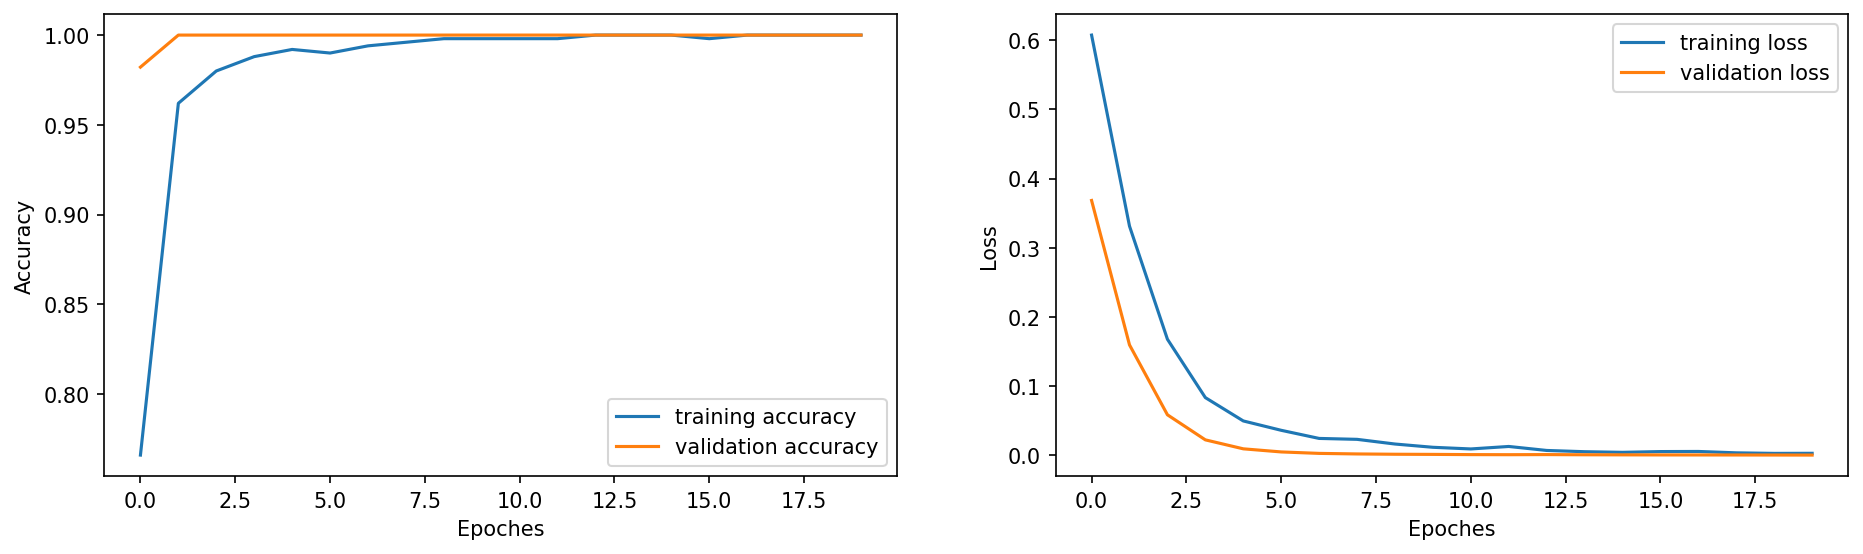

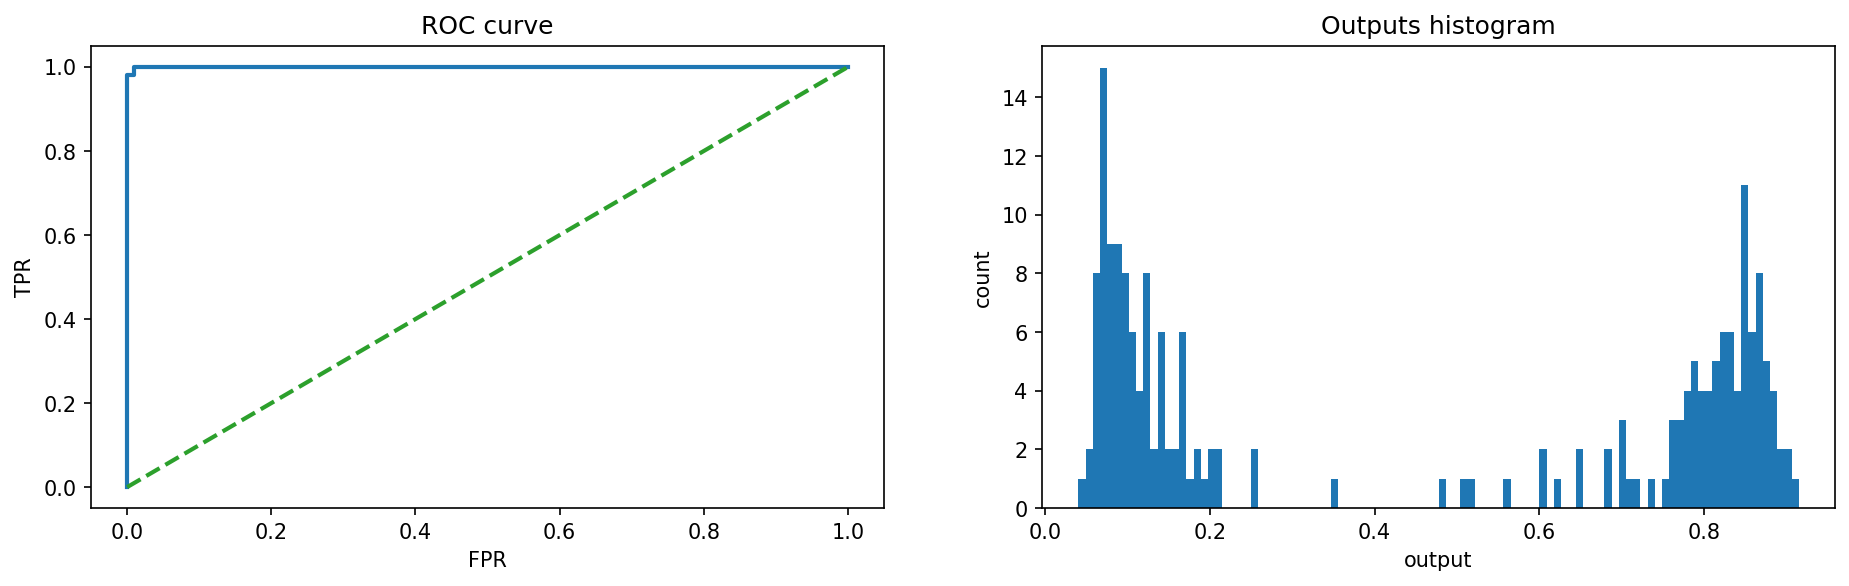

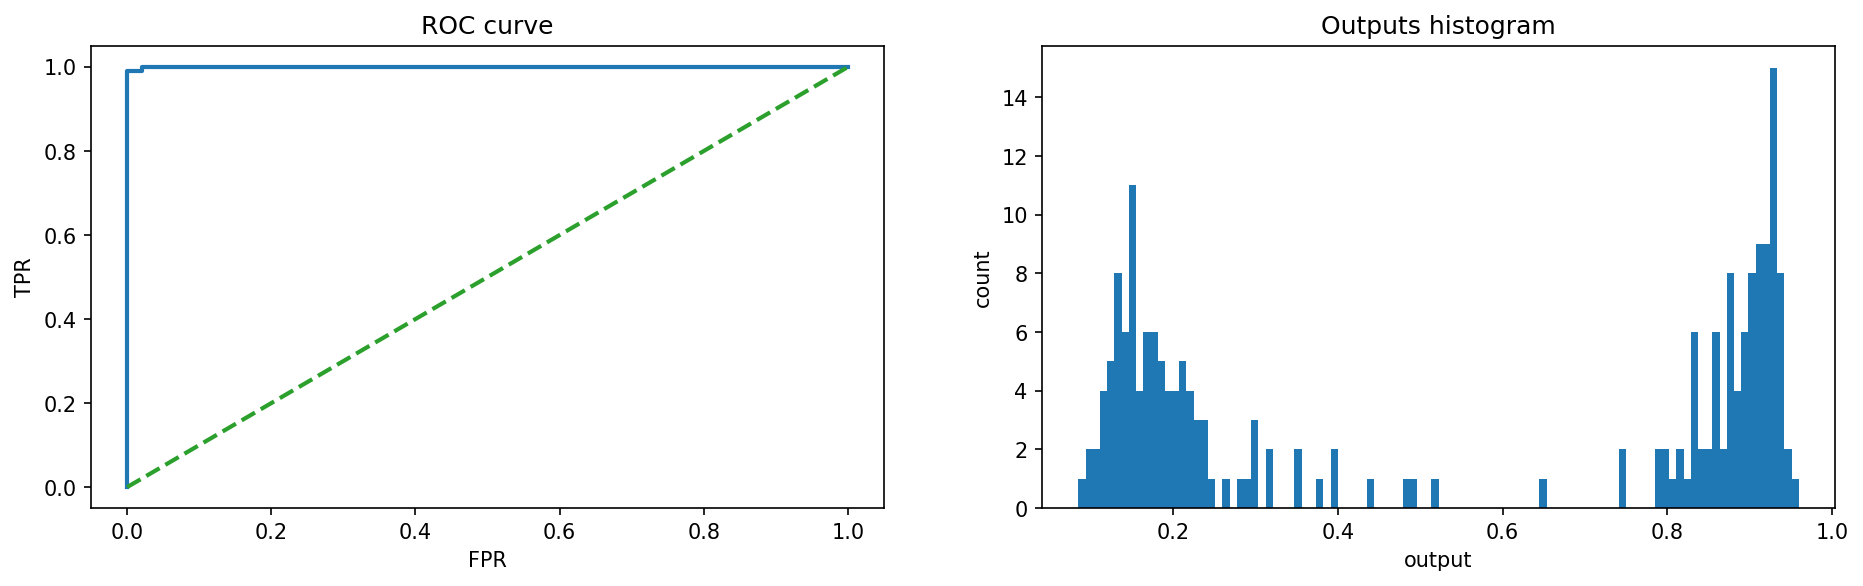

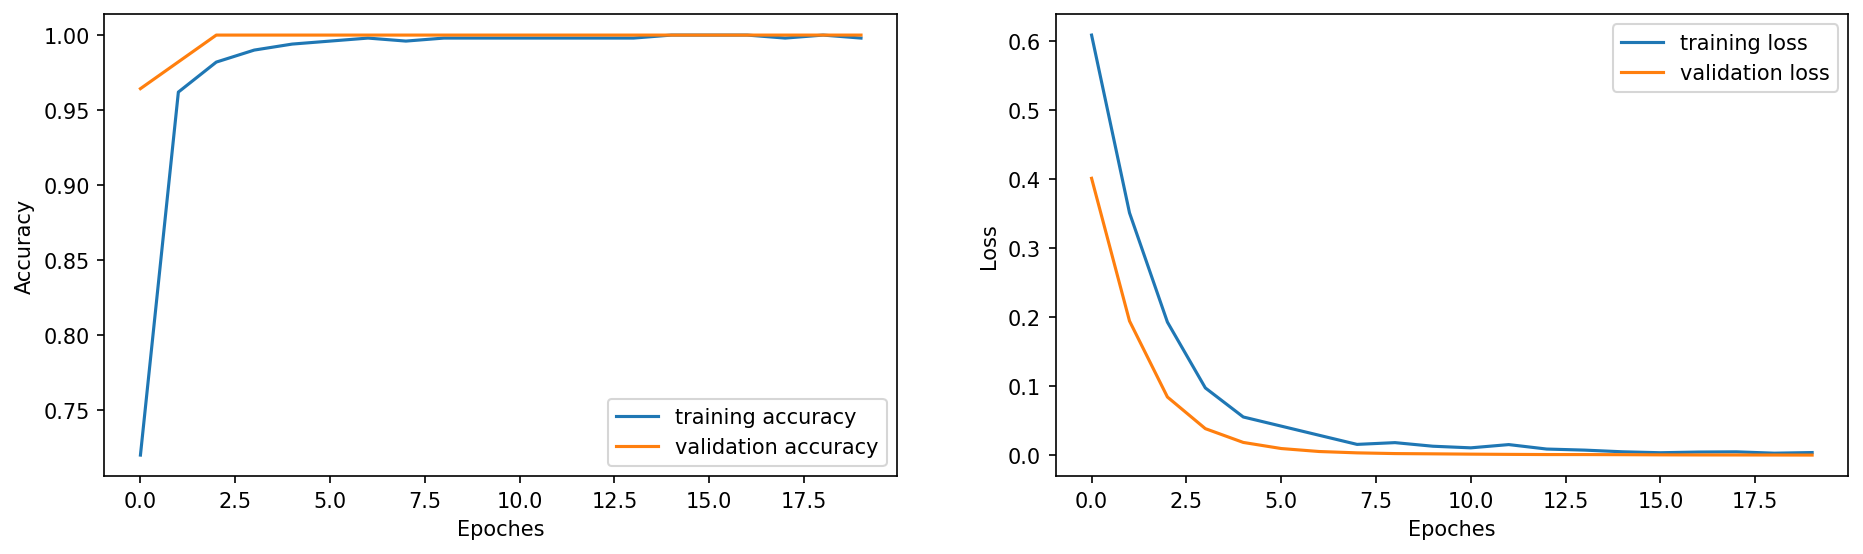

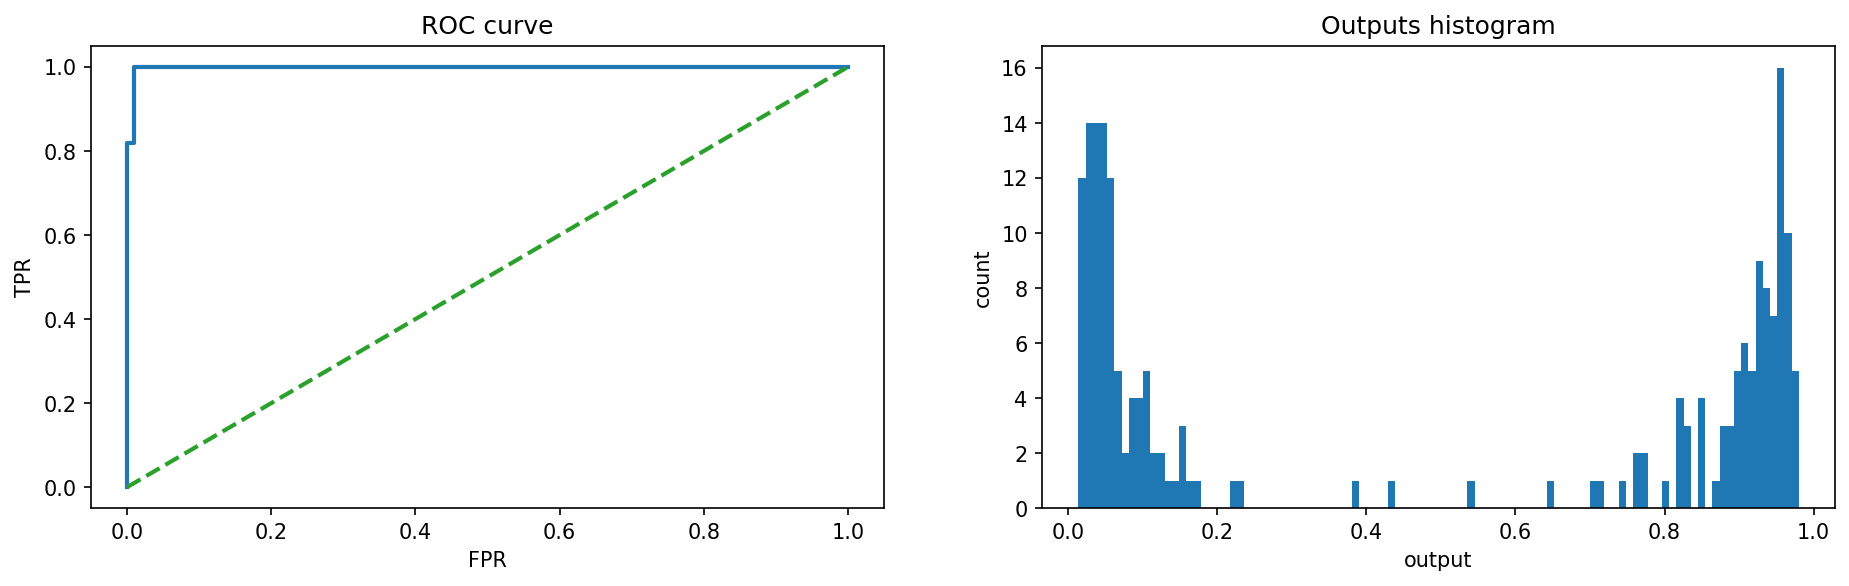

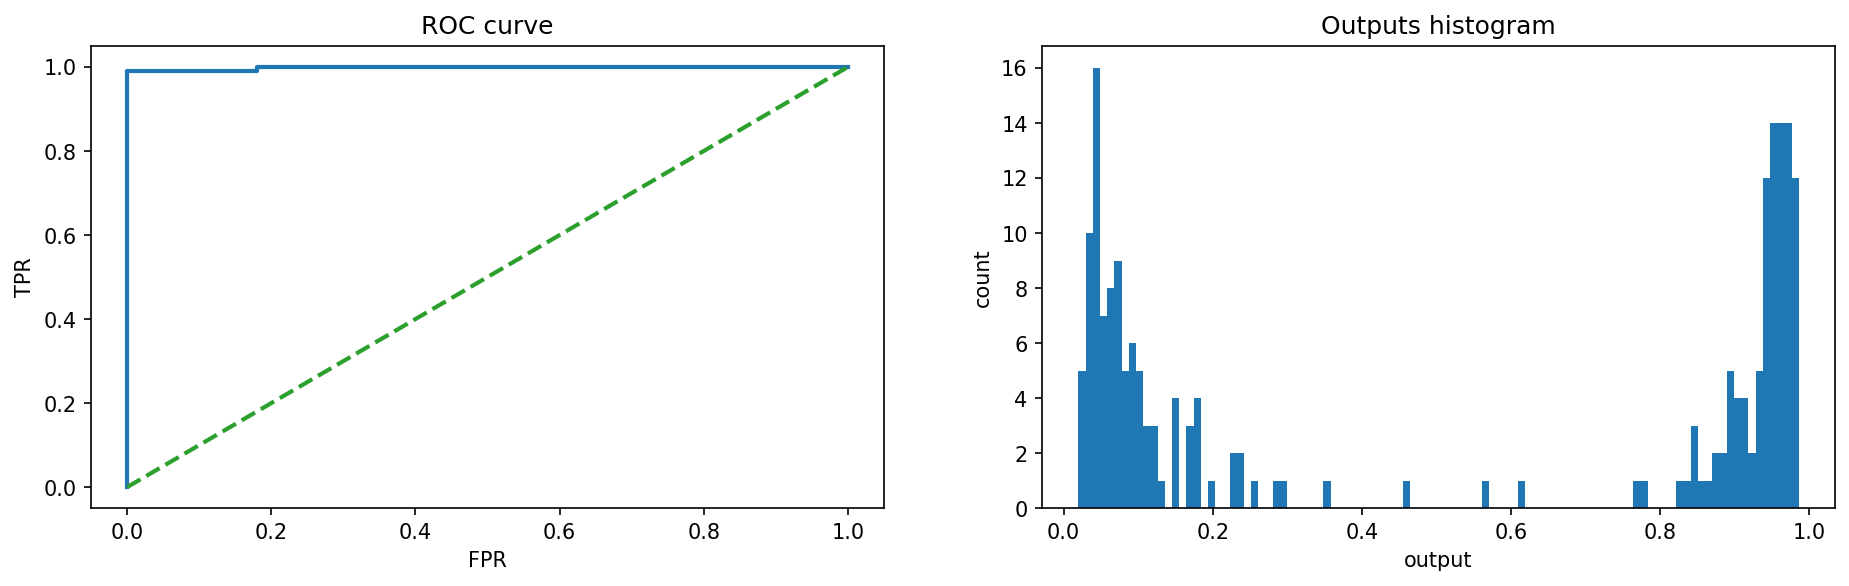

In [80]:
out_dirs = []
for i, subset in enumerate(subsets):
    
    print(f"Subset {i}")

    val_ratio = 0.1

    X_train, X_val, y_train, y_val = train_test_split(subset[0], subset[1], test_size=val_ratio, stratify=subset[1], random_state=7)

    print(X_train.shape)
    print(y_train.shape)
    print(X_val.shape)
    print(y_val.shape)

    batch_size = 100
    n_class = 2

    trainset = CovidDataset(X_train, y_train, n_class)
    trainloader = DataLoader(trainset, batch_size, shuffle = True, num_workers = 0)

    valset = CovidDataset(X_val, y_val, n_class)
    valloader = DataLoader(valset, batch_size, shuffle = True, num_workers = 0)

    model = models.CovidCNNModel(trainset)
    model.to(device)

    record_freq = 500 // batch_size
    epoch_num = 20
    train_accuracies, train_losses, val_accuracies, val_losses, out_dir = train(
        model = model, 
        trainloader = trainloader, 
        valloader = valloader, 
        epoch_num = epoch_num,
        record_freq = record_freq,
        out_dir = dataset_path)
    
    out_dirs.append(out_dir)

    plotTrainingProcess(
    record_freq, 
    trainloader, 
    train_accuracies, 
    train_losses, 
    val_accuracies, 
    val_losses,
    out_dir
    )

    model.load_state_dict(torch.load(os.path.join(out_dir, "best_model.pth")))

    testPerformance(model, testloader, out_dir = out_dir)

In [82]:
y_outs = []
accuracies = []
losses = []
for out_dir in out_dirs:
    model.load_state_dict(torch.load(os.path.join(out_dir, "best_model.pth")))
    accuracy, loss, y_out, y_true = testModel(model, testloader, analyze = True)
    y_outs.append(y_out)
    accuracies.append(accuracy)
    losses.append(loss)

In [83]:
y_outs = np.asarray(y_outs)
y_out_multi = y_outs.sum(axis=0) / y_outs.shape[0]

In [84]:
accuracy_multi = (np.argmax(y_out_multi, axis = 1) == y_true).sum() / y_true.shape[0]
accuracy_multi

0.985

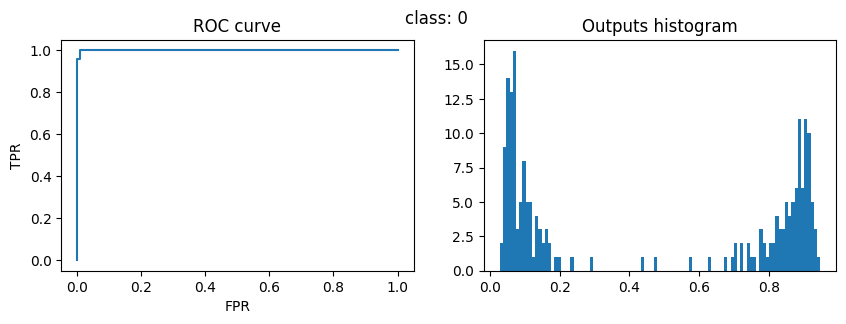

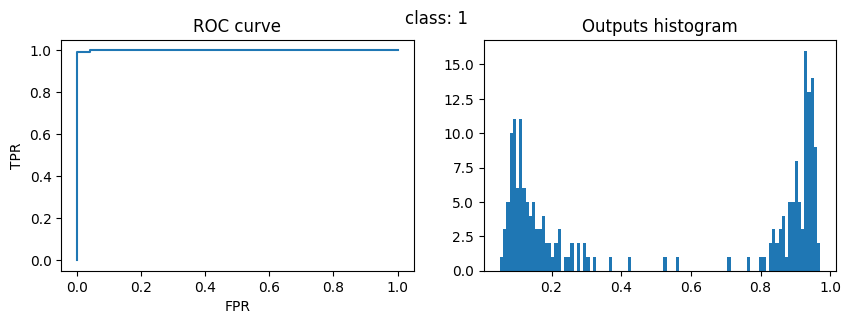

In [86]:
aucs = np.zeros(n_class)

for class_i in range(n_class):

    y_out_i = y_out_multi[:, class_i]
    y_true_i = (y_true == class_i).astype(np.int8)
    name = str(class_i)

    fpr, tpr, thresholds = roc_curve(y_true_i, y_out_i)
    auc = roc_auc_score(y_true_i, y_out_i)
    aucs[class_i] = auc

    report = f"[class: {name}] AUC: {auc}"

    plt.figure(figsize = (10, 3), dpi = 100)
    plt.suptitle(f"class: {name}")
    plt.subplot(121)
    plt.plot(fpr, tpr)
    plt.title("ROC curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")

    plt.subplot(122)
    _ = plt.hist(y_out_i, bins = 100)
    plt.title("Outputs histogram")


In [87]:
print(f"accuracy: {accuracy_multi}, AUC: {np.mean(aucs)}")

accuracy: 0.985, AUC: 0.9996
